Author: Israel Ilori | Objective: Implement a multiclass classification | Date: November 2021 | Solution: Predict product category based on a consumer complaint.

In [28]:
# import the packages
import pandas as pd 
import numpy as np
import datetime
#import plotly.express as px
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, classification_report
from tqdm import tqdm
tqdm.pandas()
import io
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Israel
[nltk_data]     Ilori\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Israel
[nltk_data]     Ilori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data = pd.read_csv('complaints.csv')

In [4]:
data.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-09-07,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,for the last 1 1/2 years the loan management c...,NaN,RUSHMORE LOAN MANAGEMENT SERVICES LLC,FL,339XX,NaN,Consent provided,Web,2021-09-07,Closed with explanation,Yes,NaN,4697705
4,2019-08-08,Mortgage,Conventional home mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,"FLAGSTAR BANK, FSB",ID,83706,NaN,NaN,Referral,2019-08-15,Closed with explanation,Yes,NaN,3342290


In [5]:
data.shape

(2335289, 18)

In [8]:
data.describe

<bound method NDFrame.describe of         Date received                                            Product  \
0          2019-06-13  Credit reporting, credit repair services, or o...   
1          2019-11-01                              Vehicle loan or lease   
2          2019-04-01  Credit reporting, credit repair services, or o...   
3          2021-09-07                                           Mortgage   
4          2019-08-08                                           Mortgage   
...               ...                                                ...   
2335284    2017-02-09                                    Debt collection   
2335285    2015-04-29                                           Mortgage   
2335286    2017-03-31                                   Credit reporting   
2335287    2017-01-16                                   Credit reporting   
2335288    2018-03-07                                           Mortgage   

                         Sub-product  \
0            

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335289 entries, 0 to 2335288
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 320.

In [11]:
# extract the required columns and rename
# clean the dataset; to remove empty columns

data_product = data[['Product', 'Consumer complaint narrative']]
data_product = data_product.rename(columns={'Product':'product', 'Consumer complaint narrative':'consumer_complaint_narrative'})
data_product = data_product.dropna()

data_product.head(5)


,product,consumer_complaint_narrative
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
3,Mortgage,for the last 1 1/2 years the loan management c...
5,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
6,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
8,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...


In [12]:
data_product.shape

(813316, 2)

In [17]:
# plot the distribution of the product category
data_product.groupby('product').consumer_complaint_narrative.count().sort_values(ascending=False)

product
Credit reporting, credit repair services, or other personal consumer reports    318650
Debt collection                                                                 158029
Mortgage                                                                         84712
Credit card or prepaid card                                                      61104
Checking or savings account                                                      37646
Credit reporting                                                                 31588
Student loan                                                                     29131
Credit card                                                                      18838
Money transfer, virtual currency, or money service                               18693
Vehicle loan or lease                                                            15123
Bank account or service                                                          14885
Payday loan, title loan, or persona

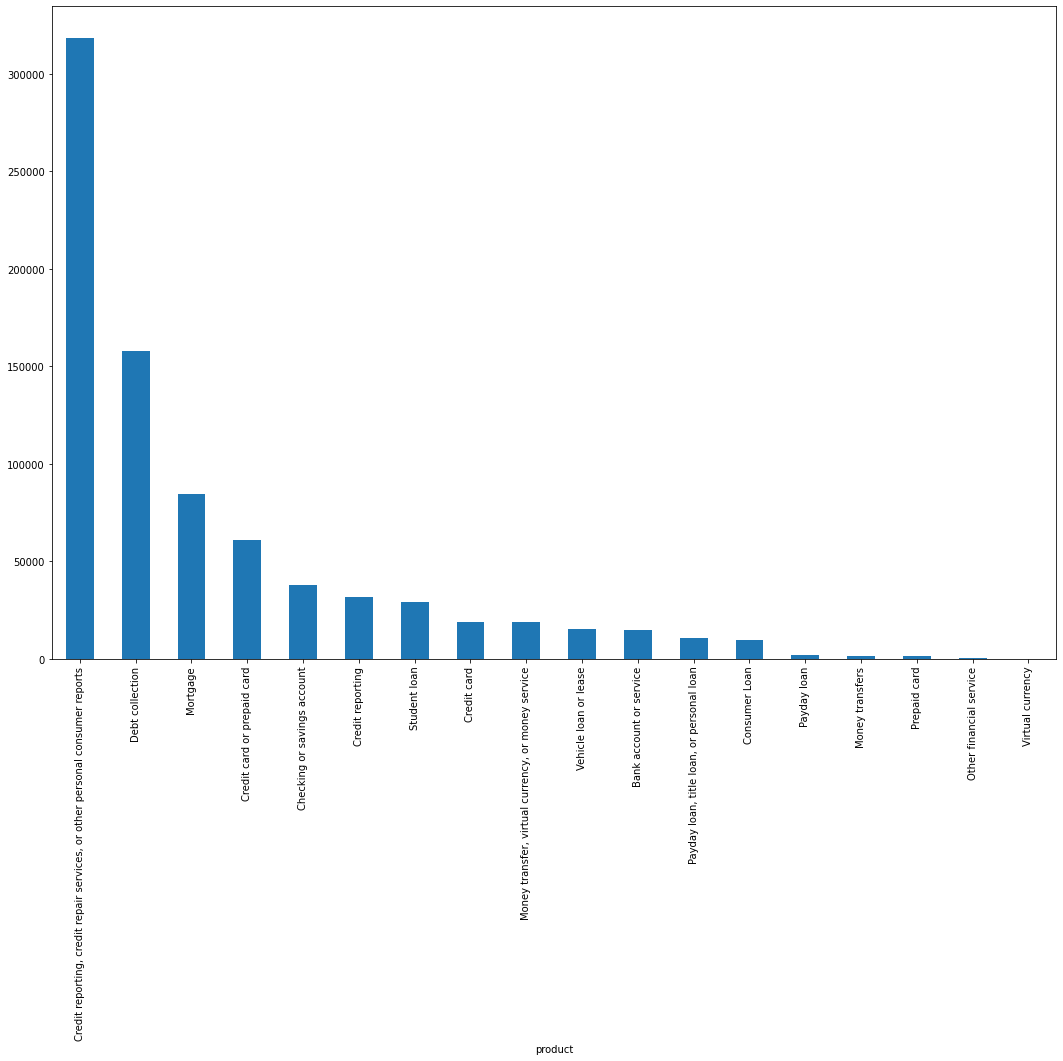

In [20]:
# visualize
fig = plt.figure(figsize=(18,12))
data_product.groupby('product').consumer_complaint_narrative.count().sort_values(ascending=False).plot.bar(ylim=0)
plt.show()

In [10]:
# data 2
data_sub_product = data[['Sub-product', 'Consumer complaint narrative']]

data_sub_product = data_sub_product.rename(columns={'Sub-product':'sub_product', 'Consumer complaint narrative':'consumer_complaint_narrative'})
data_sub_product = data_sub_product.dropna()

data_sub_product.head(5)
data_sub_product.shape

(761144, 2)

In [ ]:
# plot the distribution of the sub_product category

data_product.groupby('product').consumer_complaint_narrative.count().sort_values(ascending=False)

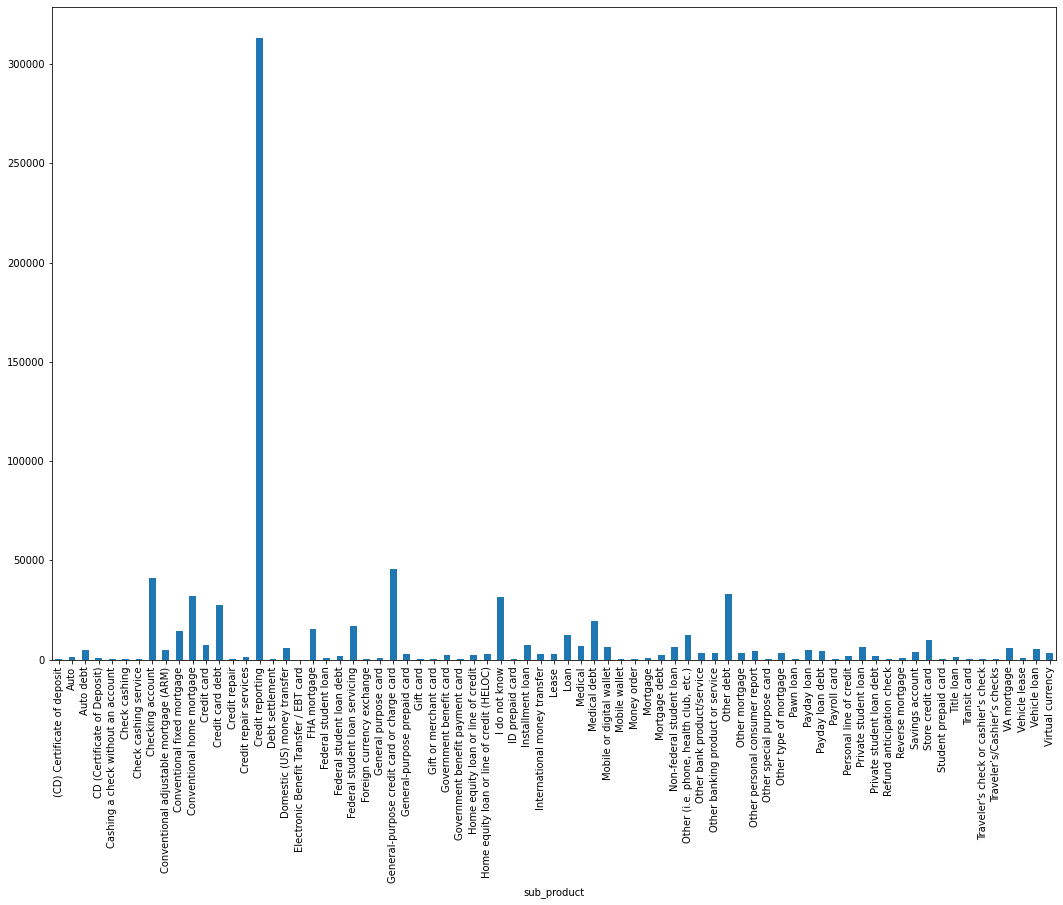

In [12]:
# plot the distribution of the sub_product category

fig = plt.figure(figsize=(18,12))
data_sub_product.groupby('sub_product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [22]:
# clean the data
remove_punctuation = str.maketrans('', '', string.punctuation)
stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    uncased = text.translate(remove_punctuation).lower()
    tokens = [token for token in nltk.word_tokenize(uncased) 
                if len(token) > 1
                and not token in stop_words
                and not (token.isnumeric() and len(token) != 4)
                and (not token.isnumeric() or token.isalpha())]
    
    return " ".join(tokens)
    

In [23]:
# create a new column for the cleaned text

data_product['cleaned_consumer_complaint_narrative'] = data_product['consumer_complaint_narrative'].progress_apply(clean_text)
data_product.head()

100%|██████████| 813316/813316 [09:07<00:00, 1485.08it/s]


,product,consumer_complaint_narrative,cleaned_consumer_complaint_narrative
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...,contacted ally friday xxxxxxxx falling behind ...
3,Mortgage,for the last 1 1/2 years the loan management c...,last years loan management company bought mort...
5,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,hello complaint three credit reporting compani...
6,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...,victim identity theft currently experian accou...
8,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...,two accounts still credit history contacting c...


In [24]:
# performing the multiclass classification

X = data_product['cleaned_consumer_complaint_narrative']
y = data_product['product']

# split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=data_product['product'])

# encode the data
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.fit_transform(y_valid)

tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(data_product['cleaned_consumer_complaint_narrative'])

X_train_vectorized = tfidf_vect.transform(X_train)
X_valid_vectorized = tfidf_vect.transform(X_valid)

model_linear = LogisticRegression(multi_class='multinomial').fit(X_train_vectorized, y_train)

C:\Users\Israel Ilori\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# make predictions on the validation set
y_pred = model_linear.predict(X_valid_vectorized)
accuracy = accuracy_score(y_pred, y_valid)

skf5 = StratifiedKFold(n_splits=5)

scores = cross_val_score(model_linear, X_train_vectorized, y_train, scoring='accuracy', cv=skf5, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.779 (0.001)


In [26]:
# classification report

print(classification_report(y_valid, y_pred, target_names=data_product['product'].unique()))

                                                                              precision    recall  f1-score   support

                                                       Vehicle loan or lease       0.65      0.36      0.46      2977
                                                                    Mortgage       0.66      0.79      0.72      7529
Credit reporting, credit repair services, or other personal consumer reports       0.51      0.21      0.30      1894
                                                 Credit card or prepaid card       0.59      0.35      0.43      3768
                                                                Student loan       0.68      0.73      0.70     12221
                          Money transfer, virtual currency, or money service       0.65      0.22      0.32      6318
                                   Payday loan, title loan, or personal loan       0.81      0.89      0.85     63730
                                                       

C:\Users\Israel Ilori\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Israel Ilori\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Israel Ilori\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [29]:
# using Random Forest

model_RF = RandomForestClassifier(random_state = 42).fit(X_train_vectorized, y_train)

In [ ]:
# make predictions on the validation set
y_pred = model_RF.predict(X_valid_vectorized)
accuracy = accuracy_score(y_pred, y_valid)

skf5 = StratifiedKFold(n_splits=5)

scores = cross_val_score(model_RF, X_train_vectorized, y_train, scoring='accuracy', cv=skf5, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))